packageのインストール方法
juliaを別途ターミナルから立ち上げて以下を入力

```
$ julia
julia> ここで]をおしてパッケージ管理モードに入る
(@v1.8) pkg> add CUDA Plots Revise
(@v1.8) pkg> add https://github.com/matsunagalab/MDToolbox.jl.git
(@v1.8) pkg> deleteをおしてパッケージ管理モードを抜ける
julia> Ctrl-dをおしてjuliaを終了
```

In [1]:
using CUDA
#using HTTP
using DelimitedFiles
using Plots
#using ChainRulesCore
using ProgressMeter
using Revise
using MDToolbox

In [2]:
function set_charge(ta::TrjArray{T,U}) where {T,U}
    charge = Array{Int64}(undef, ta.natom)
    
    atomname = deepcopy(ta.atomname)
    
    is_first = true
    
    for iatom = 1:ta.natom
        # ATOM TYPE "N"
        if ta.atomname[iatom] == "N"
            if is_first
                charge[iatom] = 1
                is_first = false
            else
                charge[iatom] = 11
            end

            # ATOM TYPE "O"
        elseif ta.resname[iatom] == "O"
            charge[iatom] = 10
        elseif ta.resname[iatom] == "OXT"
            charge[iatom] = 2

        elseif ta.resname[iatom] == "ARG" && atomname[iatom] == "NH1"
            charge[iatom] = 3
        elseif ta.resname[iatom] == "ARG" && atomname[iatom] == "NH2"
            charge[iatom] = 3
        elseif ta.resname[iatom] == "GLU" && atomname[iatom] == "OE1"
            charge[iatom] = 4
        elseif ta.resname[iatom] == "GLU" && atomname[iatom] == "OE2"
            charge[iatom] = 4
        elseif ta.resname[iatom] == "ASP" && atomname[iatom] == "OD1"
            charge[iatom] = 5
        elseif ta.resname[iatom] == "ASP" && atomname[iatom] == "OD2"
            charge[iatom] = 5
        elseif ta.resname[iatom] == "LYS" && atomname[iatom] == "NZ"
            charge[iatom] = 6
        elseif ta.resname[iatom] == "PRO" && atomname[iatom] == "N"
            charge[iatom] = 7

        else
            charge[iatom] = 8
        
        end
    end
    
    return TrjArray(ta, charge=charge)
end

function get_charge_score()
    charge_score = Array{Float64}(undef, 11)
    charge_score[1] = 1.0 #TERMINAL-N
    charge_score[2] = -1.0 #TERMINAL-O
    charge_score[3] = 0.5 #ARG,NH
    charge_score[4] = -0.5 #GLU,OE
    charge_score[5] = -0.5 #ASP,OD
    charge_score[6] = 1.0 #LYS,NZ
    charge_score[7] = -0.1 #PRO,N
    charge_score[8] = 0.0 #CA
    charge_score[9] = 0.0 #C
    charge_score[10] = -0.5 #O
    charge_score[11] = 0.5 #N
    
    return charge_score
end

function assign_charge!(grid_real::AbstractArray{T}, 
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    charge_score::AbstractVector{T}) where {T}
    
    grid_real .= zero(T)

    radius = similar(charge_score)

    radius .= T(1.0)
    spread_nearest_substitute!(grid_real, x, y, z, x_grid, y_grid, z_grid, radius)

    return nothing
end

assign_charge! (generic function with 1 method)

In [3]:

################ grid

function generate_grid(receptor_org::TrjArray{T,U}, ligand_org::TrjArray{T,U}; iframe=1, spacing=1.2) where {T,U}
    receptor = deepcopy(receptor_org)
    ligand = deepcopy(ligand_org)
    decenter!(receptor)
    orient!(ligand)
    xmin_ligand = minimum(ligand.xyz[iframe, 1:3:end])
    xmax_ligand = maximum(ligand.xyz[iframe, 1:3:end])
    size_ligand = xmax_ligand - xmin_ligand

    xmin_receptor = minimum(receptor.xyz[iframe, 1:3:end])
    xmax_receptor = maximum(receptor.xyz[iframe, 1:3:end])
    xmin_grid = xmin_receptor - size_ligand - spacing
    xmax_grid = xmax_receptor + size_ligand + spacing

    ymin_receptor = minimum(receptor.xyz[iframe, 2:3:end])
    ymax_receptor = maximum(receptor.xyz[iframe, 2:3:end])
    ymin_grid = ymin_receptor - size_ligand - spacing
    ymax_grid = ymax_receptor + size_ligand + spacing

    zmin_receptor = minimum(receptor.xyz[iframe, 3:3:end])
    zmax_receptor = maximum(receptor.xyz[iframe, 3:3:end])
    zmin_grid = zmin_receptor - size_ligand - spacing
    zmax_grid = zmax_receptor + size_ligand + spacing

    x_grid = Array{T,1}(range(xmin_grid, xmax_grid, step=spacing))
    if typeof(receptor_org.xyz) <: CuArray
        x_grid = CuArray(x_grid)
    end

    y_grid = Array{T,1}(range(ymin_grid, ymax_grid, step=spacing))
    if typeof(receptor_org.xyz) <: CuArray
        y_grid = CuArray(y_grid)
    end

    z_grid = Array{T,1}(range(zmin_grid, zmax_grid, step=spacing))
    if typeof(receptor_org.xyz) <: CuArray
        z_grid = CuArray(z_grid)
    end

    nx = length(x_grid)
    ny = length(y_grid)
    nz = length(z_grid)

    grid_real = similar(receptor_org.xyz, (nx, ny, nz))
    grid_real .= zero(T)
    grid_imag = similar(receptor_org.xyz, (nx, ny, nz))
    grid_imag .= zero(T)

    return grid_real, grid_imag, x_grid, y_grid, z_grid
end

function spread_nearest_add!(grid::AbstractArray{T},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    weight::AbstractVector{T}) where {T}

    natom = length(x)
    x_grid_delta = x_grid[2] - x_grid[1]
    y_grid_delta = y_grid[2] - y_grid[1]
    z_grid_delta = z_grid[2] - z_grid[1]

    x_grid_min = x_grid[1]
    y_grid_min = y_grid[1]
    z_grid_min = z_grid[1]

    for iatom = 1:natom
        ix = ceil(Int, (x[iatom] - x_grid_min) / x_grid_delta)
        iy = ceil(Int, (y[iatom] - y_grid_min) / y_grid_delta)
        iz = ceil(Int, (z[iatom] - z_grid_min) / z_grid_delta)
        grid[ix, iy, iz] += weight[iatom]
    end

    return nothing
end

function spread_nearest_substitute!(grid::AbstractArray{T},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    weight::AbstractVector{T}) where {T}

    natom = length(x)
    x_grid_delta = x_grid[2] - x_grid[1]
    y_grid_delta = y_grid[2] - y_grid[1]
    z_grid_delta = z_grid[2] - z_grid[1]

    x_grid_min = x_grid[1]
    y_grid_min = y_grid[1]
    z_grid_min = z_grid[1]

    for iatom = 1:natom
        ix = ceil(Int, (x[iatom] - x_grid_min) / x_grid_delta)
        iy = ceil(Int, (y[iatom] - y_grid_min) / y_grid_delta)
        iz = ceil(Int, (z[iatom] - z_grid_min) / z_grid_delta)
        grid[ix, iy, iz] = weight[iatom]
    end

    return nothing
end

function spread_neighbors_add!(grid::AbstractArray{T},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    weight::AbstractVector{T}, rcut::AbstractVector{T}) where {T}

    natom = length(x)
    nx, ny, nz = size(grid)
    for iatom = 1:natom
        for ix = 1:nx
            dx = x[iatom] - x_grid[ix]
            if abs(dx) > rcut[iatom]
                continue
            end
            for iy = 1:ny
                dy = y[iatom] - y_grid[iy]
                if abs(dy) > rcut[iatom]
                    continue
                end
                for iz = 1:nz
                    dz = z[iatom] - z_grid[iz]
                    if abs(dz) > rcut[iatom]
                        continue
                    end
                    d = dx * dx + dy * dy + dz * dz
                    if d < rcut[iatom] * rcut[iatom]
                        grid[ix, iy, iz] += weight[iatom]
                    end
                end
            end
        end
    end

    return nothing
end


function spread_neighbors_substitute!(grid::AbstractArray{T2},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    weight::AbstractVector{T}, rcut::AbstractVector{T}) where {T2,T}

    natom = length(x)
    nx, ny, nz = size(grid)

    for iatom = 1:natom
        for ix = 1:nx
            dx = x[iatom] - x_grid[ix]
            if abs(dx) > rcut[iatom]
                continue
            end
            for iy = 1:ny
                dy = y[iatom] - y_grid[iy]
                if abs(dy) > rcut[iatom]
                    continue
                end
                for iz = 1:nz
                    dz = z[iatom] - z_grid[iz]
                    if abs(dz) > rcut[iatom]
                        continue
                    end
                    d = dx * dx + dy * dy + dz * dz
                    if d < rcut[iatom] * rcut[iatom]
                        grid[ix, iy, iz] = weight[iatom]
                    end
                end
            end
        end
    end

    return nothing
end


#####################################################

function assign_sc_receptor_plus!(grid_real::AbstractArray{T},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    radius::AbstractVector{T}, id_surface::AbstractVector) where {T}

    
    grid_real .= zero(T)

    
    x_s = x[id_surface]
    y_s = y[id_surface]
    z_s = z[id_surface]
    radius_s = radius[id_surface]
    weight_s = similar(radius_s)

    x_c = x[.!id_surface]
    y_c = y[.!id_surface]
    z_c = z[.!id_surface]
    radius_c = radius[.!id_surface]
    weight_c = similar(radius_c)

    weight_s .= T(1.0)
    spread_neighbors_substitute!(grid_real, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s .+ T(3.4))
    weight_s .= T(1.0)
    spread_neighbors_substitute!(grid_real, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s .* T(sqrt(0.8)))
    weight_c .= T(1.0)
    spread_neighbors_substitute!(grid_real, x_c, y_c, z_c, x_grid, y_grid, z_grid, weight_c, radius_c .* T(sqrt(1.5)))
     
    
    return nothing
end

function assign_sc_ligand_plus!(grid_real::AbstractArray{T},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    radius::AbstractVector{T}, id_surface::AbstractVector) where {T}

    
    grid_real .= zero(T)

    
    x_s = x[id_surface]
    y_s = y[id_surface]
    z_s = z[id_surface]
    radius_s = radius[id_surface]
    weight_s = similar(radius_s)

    x_c = x[.!id_surface]
    y_c = y[.!id_surface]
    z_c = z[.!id_surface]
    radius_c = radius[.!id_surface]
    weight_c = similar(radius_c)

    weight_s .= T(1.0)
    spread_neighbors_substitute!(grid_real, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s)

    weight_c .= T(1.0)
    spread_neighbors_substitute!(grid_real, x_c, y_c, z_c, x_grid, y_grid, z_grid, weight_c, radius_c .* T(sqrt(1.5)))
     
    
    return nothing
end

function assign_sc_receptor_minus!(grid_imag::AbstractArray{T},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    radius::AbstractVector{T}, id_surface::AbstractVector) where {T}

    
    grid_imag .= zero(T)

    
    x_s = x[id_surface]
    y_s = y[id_surface]
    z_s = z[id_surface]
    radius_s = radius[id_surface]
    weight_s = similar(radius_s)

    x_c = x[.!id_surface]
    y_c = y[.!id_surface]
    z_c = z[.!id_surface]
    radius_c = radius[.!id_surface]
    weight_c = similar(radius_c)

    weight_s .= T(3.5)
    spread_neighbors_substitute!(grid_imag, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s .+ T(3.4))
    weight_s .= T(12.25)
    spread_neighbors_substitute!(grid_imag, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s .* T(sqrt(0.8)))
    weight_c .= T(12.25)
    spread_neighbors_substitute!(grid_imag, x_c, y_c, z_c, x_grid, y_grid, z_grid, weight_c, radius_c .* T(sqrt(1.5)))
     
    
    return nothing
end
    
function assign_sc_ligand_minus!(grid_imag::AbstractArray{T},
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    radius::AbstractVector{T}, id_surface::AbstractVector) where {T}

    
    grid_imag .= zero(T)

    
    x_s = x[id_surface]
    y_s = y[id_surface]
    z_s = z[id_surface]
    radius_s = radius[id_surface]
    weight_s = similar(radius_s)

    x_c = x[.!id_surface]
    y_c = y[.!id_surface]
    z_c = z[.!id_surface]
    radius_c = radius[.!id_surface]
    weight_c = similar(radius_c)

    weight_s .= T(3.5)
    spread_neighbors_substitute!(grid_imag, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s)

    weight_c .= T(12.25)
    spread_neighbors_substitute!(grid_imag, x_c, y_c, z_c, x_grid, y_grid, z_grid, weight_c, radius_c .* T(sqrt(1.5)))
     
    
    return nothing
end
###################################################

# function assign_sc_receptor!(grid_real::AbstractArray{T}, grid_imag::AbstractArray{T},
#     x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
#     x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
#     radius::AbstractVector{T}, id_surface::AbstractVector) where {T}

#     grid_real .= zero(T)
#     grid_imag .= zero(T)

#     x_s = x[id_surface]
#     y_s = y[id_surface]
#     z_s = z[id_surface]
#     radius_s = radius[id_surface]
#     weight_s = similar(radius_s)

#     x_c = x[.!id_surface]
#     y_c = y[.!id_surface]
#     z_c = z[.!id_surface]
#     radius_c = radius[.!id_surface]
#     weight_c = similar(radius_c)

#     weight_s .= T(1.0)
#     spread_neighbors_substitute!(grid_real, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s .+ T(3.4))
#     weight_s .= T(0.0)
#     spread_neighbors_substitute!(grid_real, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s .* T(sqrt(0.8)))
#     weight_c .= T(0.0)
#     spread_neighbors_substitute!(grid_real, x_c, y_c, z_c, x_grid, y_grid, z_grid, weight_c, radius_c .* T(sqrt(1.5)))

#     weight_s .= T(9.0)
#     spread_neighbors_substitute!(grid_imag, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s .* T(sqrt(0.8)))
#     weight_c .= T(9.0)
#     spread_neighbors_substitute!(grid_imag, x_c, y_c, z_c, x_grid, y_grid, z_grid, weight_c, radius_c .* T(sqrt(1.5)))
     
#     return nothing
# end

# function assign_sc_ligand!(grid_real::AbstractArray{T}, grid_imag::AbstractArray{T},
#     x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
#     x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
#     radius::AbstractVector{T}, id_surface::AbstractVector) where {T}

#     grid_real .= zero(T)
#     grid_imag .= zero(T)

#     x_s = x[id_surface]
#     y_s = y[id_surface]
#     z_s = z[id_surface]
#     radius_s = radius[id_surface]
#     weight_s = similar(radius_s)

#     x_c = x[.!id_surface]
#     y_c = y[.!id_surface]
#     z_c = z[.!id_surface]
#     radius_c = radius[.!id_surface]
#     weight_c = similar(radius_c)
    
#     weight_s .= T(1.0)
#     spread_neighbors_substitute!(grid_real, x_s, y_s, z_s, x_grid, y_grid, z_grid, weight_s, radius_s)

#     weight_c .= T(9.0)
#     spread_neighbors_substitute!(grid_imag, x_c, y_c, z_c, x_grid, y_grid, z_grid, weight_c, radius_c .* T(sqrt(1.5)))

#     # check_neighbors_ligand!(grid_real, grid_imag)

#     return nothing
# end

function assign_Rij!(grid_real::AbstractArray{T}, 
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
    iface_ij::AbstractVector{T}) where {T}

    grid_real .= zero(T)

    radius = similar(iface_ij)
    radius .= T(6.0)
    spread_neighbors_add!(grid_real, x, y, z, x_grid, y_grid, z_grid, iface_ij, radius)

    return nothing
end

function assign_Li!(grid_real::AbstractArray{T}, 
    x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
    x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T}
    ) where {T}

    grid_real .= zero(T)

    radius = similar(x)
    radius .= T(1.0)
    spread_nearest_substitute!(grid_real, x, y, z, x_grid, y_grid, z_grid, radius)

    return nothing
end

# function assign_ds!(grid_real::AbstractArray{T}, grid_imag::AbstractArray{T},
#     x::AbstractVector{T}, y::AbstractVector{T}, z::AbstractVector{T},
#     x_grid::AbstractVector{T}, y_grid::AbstractVector{T}, z_grid::AbstractVector{T},
#     iface_ij::AbstractVector{T}) where {T}

#     grid_real .= zero(T)
#     grid_imag .= zero(T)

#     radius = similar(iface_ij)
#     radius .= T(6.0)
#     spread_neighbors_add!(grid_real, x, y, z, x_grid, y_grid, z_grid, iface_ij, radius)

#     radius .= T(1.0)
#     spread_nearest_substitute!(grid_imag, x, y, z, x_grid, y_grid, z_grid, radius)

#     return nothing
# end

################ docking

function docking_score_elec(receptor_org::TrjArray{T,U},
        ligands_org::TrjArray{T,U}, alpha::T, iface_ij::AbstractArray{T}, 
        beta::T, charge_score::AbstractArray{T}) where {T,U}
    spacing = 3.0
    receptor = deepcopy(receptor_org)
    ligands = deepcopy(ligands_org)

    decenter!(receptor)
    decenter!(ligands)

    grid_real, grid_imag, x_grid, y_grid, z_grid = generate_grid(receptor, ligands, spacing=spacing)
    nxyz = T(prod(size(grid_real)))

    com = centerofmass(receptor)
    receptor.xyz[:, 1:3:end] .= receptor.xyz[:, 1:3:end] .- com.xyz[:, 1:1]
    receptor.xyz[:, 2:3:end] .= receptor.xyz[:, 2:3:end] .- com.xyz[:, 2:2]
    receptor.xyz[:, 3:3:end] .= receptor.xyz[:, 3:3:end] .- com.xyz[:, 3:3]
    ligands.xyz[:, 1:3:end] .= ligands.xyz[:, 1:3:end] .- com.xyz[:, 1:1]
    ligands.xyz[:, 2:3:end] .= ligands.xyz[:, 2:3:end] .- com.xyz[:, 2:2]
    ligands.xyz[:, 3:3:end] .= ligands.xyz[:, 3:3:end] .- com.xyz[:, 3:3]

    # receptor.mass .= iface_ij[receptor.atomtype_id]
    # ligands.mass .= iface_ij[ligands.atomtype_id]

    x = receptor.xyz[1, 1:3:end]
    y = receptor.xyz[1, 2:3:end]
    z = receptor.xyz[1, 3:3:end]
    id_surface = receptor.sasa .> 1.0

    ##########################################
    
    assign_sc_receptor_plus!(grid_real, x, y, z, x_grid, y_grid, z_grid, receptor.radius, id_surface)
    assign_sc_receptor_minus!(grid_imag, x, y, z, x_grid, y_grid, z_grid, receptor.radius, id_surface)
    #assign_sc_receptor!(grid_real, grid_imag, x, y, z, x_grid, y_grid, z_grid, receptor.radius, id_surface)
    grid_sc_receptor = grid_real .+ im .* grid_imag
    
    ##########################################

    # assign_ds!(grid_real, grid_imag, x, y, z, x_grid, y_grid, z_grid, receptor.mass)
    # grid_ds_receptor = grid_real .+ im .* grid_imag

    x = ligands.xyz[1, 1:3:end]
    y = ligands.xyz[1, 2:3:end]
    z = ligands.xyz[1, 3:3:end]

    x2 = receptor.xyz[1, 1:3:end]
    y2 = receptor.xyz[1, 2:3:end]
    z2 = receptor.xyz[1, 3:3:end]

    id_surface = ligands.sasa .> 1.0

    grid_sc_ligand = deepcopy(grid_sc_receptor)
    # grid_iface_ligand = deepcopy(grid_real)
    # grid_iface_receptor = deepcopy(grid_real)
    score_sc = similar(grid_real, ligands.nframe)
    score_iface = similar(grid_real, ligands.nframe)
    score_iface .= zero(T)
    score_elec = similar(grid_real, ligands.nframe)
    score_elec .= zero(T)
    score_total = similar(grid_real, ligands.nframe)

    @showprogress for iframe = 1:ligands.nframe
        x .= ligands.xyz[iframe, 1:3:end]
        y .= ligands.xyz[iframe, 2:3:end]
        z .= ligands.xyz[iframe, 3:3:end]

        ###################################################
        
#         assign_sc_ligand!(grid_real, grid_imag, x, y, z, x_grid, y_grid, z_grid, ligands.radius, id_surface)
#         grid_sc_ligand .= grid_real .+ im .* grid_imag
#         multi = grid_sc_receptor .* grid_sc_ligand
#         score_sc[iframe] = sum(real.(multi)) - sum(imag.(multi))

        assign_sc_ligand_plus!(grid_real, x, y, z, x_grid, y_grid, z_grid, ligands.radius, id_surface)
        assign_sc_ligand_minus!(grid_imag, x, y, z, x_grid, y_grid, z_grid, ligands.radius, id_surface)
        grid_sc_ligand .= grid_real .+ im .* grid_imag 
        multi = grid_sc_receptor .* grid_sc_ligand
        score_sc[iframe] = sum(real.(multi)) - sum(imag.(multi)) 
        
        
        ##################################################        
        
        # assign_ds!(grid_real, grid_imag, x, y, z, x_grid, y_grid, z_grid, ligands.mass)
        # grid_ds_ligand .= grid_real .+ im .* grid_imag
        # multi = grid_ds_receptor .* grid_ds_ligand
        # score_ds[iframe] = T(0.5) * sum(imag(multi))

        for i = 1:12
            idx = ligands.atomtype_id .== i 
            assign_Li!(grid_real, x[idx], y[idx], z[idx], x_grid, y_grid, z_grid)
            for j = 1:12
                k = 12 * (j-1) + i 
                receptor.mass .= iface_ij[k]
                idx = receptor.atomtype_id .== j
                assign_Rij!(grid_imag, x2[idx], y2[idx], z2[idx], x_grid, y_grid, z_grid, receptor.mass[idx])
                score_iface[iframe] += sum(grid_real .* grid_imag)
            end
        end 
        
        for l = 1:11
            idx = ligands.atomtype_id .== l
            ligands.mass .= charge_score[l]
            assign_charge!(grid_real, x[idx], y[idx], z[idx], x_grid, y_grid, z_grid, ligands.mass[idx])
            score_elec[iframe] += sum(grid_real)
        end


        score_total[iframe] = alpha .* score_sc[iframe] .+ score_iface[iframe] .- beta ./ beta .* score_elec[iframe]
    end

    return score_total
end


docking_score_elec (generic function with 1 method)

In [4]:
function docking_score(receptor_org::TrjArray{T,U},
        ligands_org::TrjArray{T,U}, alpha::T, iface_ij::AbstractArray{T}
        ) where {T,U}
    spacing = 3.0
    receptor = deepcopy(receptor_org)
    ligands = deepcopy(ligands_org)

    decenter!(receptor)
    decenter!(ligands)

    grid_real, grid_imag, x_grid, y_grid, z_grid = generate_grid(receptor, ligands, spacing=spacing)
    nxyz = T(prod(size(grid_real)))

    com = centerofmass(receptor)
    receptor.xyz[:, 1:3:end] .= receptor.xyz[:, 1:3:end] .- com.xyz[:, 1:1]
    receptor.xyz[:, 2:3:end] .= receptor.xyz[:, 2:3:end] .- com.xyz[:, 2:2]
    receptor.xyz[:, 3:3:end] .= receptor.xyz[:, 3:3:end] .- com.xyz[:, 3:3]
    ligands.xyz[:, 1:3:end] .= ligands.xyz[:, 1:3:end] .- com.xyz[:, 1:1]
    ligands.xyz[:, 2:3:end] .= ligands.xyz[:, 2:3:end] .- com.xyz[:, 2:2]
    ligands.xyz[:, 3:3:end] .= ligands.xyz[:, 3:3:end] .- com.xyz[:, 3:3]

    # receptor.mass .= iface_ij[receptor.atomtype_id]
    # ligands.mass .= iface_ij[ligands.atomtype_id]

    x = receptor.xyz[1, 1:3:end]
    y = receptor.xyz[1, 2:3:end]
    z = receptor.xyz[1, 3:3:end]
    id_surface = receptor.sasa .> 1.0

    ##########################################
    
    assign_sc_receptor_plus!(grid_real, x, y, z, x_grid, y_grid, z_grid, receptor.radius, id_surface)
    assign_sc_receptor_minus!(grid_imag, x, y, z, x_grid, y_grid, z_grid, receptor.radius, id_surface)
    #assign_sc_receptor!(grid_real, grid_imag, x, y, z, x_grid, y_grid, z_grid, receptor.radius, id_surface)
    grid_sc_receptor = grid_real .+ im .* grid_imag
    
    ##########################################

    # assign_ds!(grid_real, grid_imag, x, y, z, x_grid, y_grid, z_grid, receptor.mass)
    # grid_ds_receptor = grid_real .+ im .* grid_imag

    x = ligands.xyz[1, 1:3:end]
    y = ligands.xyz[1, 2:3:end]
    z = ligands.xyz[1, 3:3:end]

    x2 = receptor.xyz[1, 1:3:end]
    y2 = receptor.xyz[1, 2:3:end]
    z2 = receptor.xyz[1, 3:3:end]

    id_surface = ligands.sasa .> 1.0

    grid_sc_ligand = deepcopy(grid_sc_receptor)
    # grid_iface_ligand = deepcopy(grid_real)
    # grid_iface_receptor = deepcopy(grid_real)
    score_sc = similar(grid_real, ligands.nframe)
    score_iface = similar(grid_real, ligands.nframe)
    score_iface .= zero(T)
    score_total = similar(grid_real, ligands.nframe)

    @showprogress for iframe = 1:ligands.nframe
        x .= ligands.xyz[iframe, 1:3:end]
        y .= ligands.xyz[iframe, 2:3:end]
        z .= ligands.xyz[iframe, 3:3:end]

        ###################################################
        
#         assign_sc_ligand!(grid_real, grid_imag, x, y, z, x_grid, y_grid, z_grid, ligands.radius, id_surface)
#         grid_sc_ligand .= grid_real .+ im .* grid_imag
#         multi = grid_sc_receptor .* grid_sc_ligand
#         score_sc[iframe] = sum(real.(multi)) - sum(imag.(multi))

        assign_sc_ligand_plus!(grid_real, x, y, z, x_grid, y_grid, z_grid, ligands.radius, id_surface)
        assign_sc_ligand_minus!(grid_imag, x, y, z, x_grid, y_grid, z_grid, ligands.radius, id_surface)
        grid_sc_ligand .= grid_real .+ im .* grid_imag 
        multi = grid_sc_receptor .* grid_sc_ligand
        score_sc[iframe] = sum(real.(multi)) - sum(imag.(multi)) 
        
        
        ##################################################        
        
        # assign_ds!(grid_real, grid_imag, x, y, z, x_grid, y_grid, z_grid, ligands.mass)
        # grid_ds_ligand .= grid_real .+ im .* grid_imag
        # multi = grid_ds_receptor .* grid_ds_ligand
        # score_ds[iframe] = T(0.5) * sum(imag(multi))

        for i = 1:12
            idx = ligands.atomtype_id .== i 
            assign_Li!(grid_real, x[idx], y[idx], z[idx], x_grid, y_grid, z_grid)
            for j = 1:12
                k = 12 * (j-1) + i 
                receptor.mass .= iface_ij[k]
                idx = receptor.atomtype_id .== j
                assign_Rij!(grid_imag, x2[idx], y2[idx], z2[idx], x_grid, y_grid, z_grid, receptor.mass[idx])
                score_iface[iframe] += sum(grid_real .* grid_imag)
            end
        end 


        score_total[iframe] = alpha .* score_sc[iframe] .+ score_iface[iframe] 
    end

    return score_total
end


docking_score (generic function with 1 method)

In [5]:
#device!(2)

In [6]:
#CUDA.cu(rand(3,3))

In [7]:
ENV["COLUMNS"]=130; #display width for MDToolbox

# load deocoy structures

In [8]:
ntop = 100

100

In [9]:
pdb = mdload("1KXQ/complex.1.pdb")
receptor = pdb[1:1, 1:3908]
ligands = pdb[1:1, 3909:end]

for i = 2:ntop
    pdb = mdload("1KXQ/complex.$(i).pdb")
    ligands = [ligands; pdb[1:1, 3909:end]]
end

In [10]:
d = readdlm("1KXQ/1KXQ.zd3.0.2.fg.fixed.out.rmsds")
rmsds = d[1:ntop, 2]

100-element Vector{Float64}:
 11.19
  4.77
  4.77
 11.54
  4.29
  4.53
  5.33
  4.24
  4.42
 11.44
  3.89
  4.31
 11.12
  ⋮
 19.84
  0.93
 19.86
 19.66
 12.17
  5.03
  2.18
 12.62
 15.78
  4.79
  8.78
 19.18

# prepare docking score calculation

In [11]:
# vdW radius
receptor = MDToolbox.set_radius(receptor)
ligands = MDToolbox.set_radius(ligands);

In [12]:
# charge
# receptor = MDToolbox.set_charge(receptor)
# ligands = MDToolbox.set_charge(ligands);

In [13]:
# SASA
receptor = MDToolbox.compute_sasa(receptor)
ligands = MDToolbox.compute_sasa(ligands);

In [14]:
# ACE scores
receptor = MDToolbox.set_atomtype_id(receptor)
ligands = MDToolbox.set_atomtype_id(ligands)

iface_score = MDToolbox.get_iface_ij()
receptor = TrjArray(receptor, mass=iface_score[receptor.atomtype_id])
ligands = TrjArray(ligands, mass=iface_score[ligands.atomtype_id]);

In [15]:
# ELEC
ligands = set_charge(ligands)
charge = get_charge_score()
# receptor = TrjArray(receptor, mass=iface_score[receptor.atomtype_id])
# ligands = TrjArray(ligands, mass=charge[ligands.atomtype_id]);

In [16]:
#CUDA.device!(0)

In [17]:
#device!(1)

In [18]:
#gpu(receptor)

In [19]:
#receptor = gpu(receptor)

In [20]:
# if CUDA.functional()
#     receptor = gpu(receptor)
#     ligands = gpu(ligands)
# end

In [21]:
receptor.xyz

1×11724 Matrix{Float64}:
 14.376  -5.731  -7.538  13.09  -6.246  -7.936  12.362  -6.908  …  -3.31  31.897  6.658  -4.83  33.167  12.186  -5.564  32.576

In [22]:
ligands.xyz

100×2748 Matrix{Float64}:
 -13.274   -8.889   -5.811  -12.604   -9.056   -7.12   -13.378  …  -18.219   26.187  -28.689  -20.366   26.92   -27.066
 -25.91    20.33    -7.936  -26.761   20.685   -9.094  -26.625     -41.48   -14.835  -25.233  -39.481  -16.317  -23.973
 -24.023   21.384   -7.936  -24.831   21.826   -9.094  -24.797     -43.182  -11.961  -25.233  -41.35   -13.644  -23.973
 -12.587   -9.927   -6.262  -12.078  -10.038   -7.648  -13.014     -21.672   25.405  -27.412  -23.628   26.013  -25.518
 -25.634   20.159   -7.061  -26.43    20.68    -8.194  -26.288     -41.823  -12.106  -28.857  -39.923  -13.802  -27.721
 -24.193   20.524   -6.168  -25.24    21.05    -7.072  -25.31   …  -42.342  -11.488  -26.761  -40.139  -13.092  -26.171
 -24.078   22.495  -10.137  -24.943   22.785  -11.302  -24.931     -43.038  -13.004  -22.725  -41.113  -14.493  -21.362
 -27.384   17.743   -7.061  -28.231   18.178   -8.194  -28.003     -40.113  -16.037  -28.857  -38.045  -17.525  -27.721
 -25.599   18.

In [23]:
iface_score

12×12 Matrix{Float64}:
  0.678   0.133  -0.007   0.727   0.091  -0.742  -0.625  -0.064  -0.382  -0.302   1.221   0.187
  0.133   0.18    0.065   0.295   0.057  -0.631  -0.663   0.612   0.342  -0.275   0.604   0.248
 -0.007   0.065  -0.145   0.093  -0.265  -1.078  -1.176   0.636   0.355  -0.552   0.483   0.109
  0.727   0.295   0.093   0.696  -0.016  -0.735  -0.804   0.525   0.144  -0.202   1.116   0.477
  0.091   0.057  -0.265  -0.016  -0.601  -0.928  -1.046   0.644   0.615  -0.573   0.062  -0.034
 -0.742  -0.631  -1.078  -0.735  -0.928  -0.914  -1.696  -0.577  -0.43   -1.495  -0.303  -0.867
 -0.625  -0.663  -1.176  -0.804  -1.046  -1.696  -1.938  -0.214   0.015  -1.771   0.092  -1.04
 -0.064   0.612   0.636   0.525   0.644  -0.577  -0.214   1.62    1.233  -0.001   0.368   0.822
 -0.382   0.342   0.355   0.144   0.615  -0.43    0.015   1.233   1.09    0.05   -0.024   0.757
 -0.302  -0.275  -0.552  -0.202  -0.573  -1.495  -1.771  -0.001   0.05   -1.606   0.253  -0.572
  1.221   0.604   

In [24]:
charge

11-element Vector{Float64}:
  1.0
 -1.0
  0.5
 -0.5
 -0.5
  1.0
 -0.1
  0.0
  0.0
 -0.5
  0.5

# perform docking score calculation for decoy structures

In [25]:
iface_trained = [0.90828675, 0.10770475, -0.36209023, 0.5656486, -0.094549924, -1.0140382, -1.3266196, -0.111358136, -0.37396756, -0.12201775, 1.1326307, 0.20464702, 0.17319715, 0.07356769, -0.07072987, 0.27021262, -0.09005466, -0.7761774, -0.36793923, 0.6075699, 0.24668607, -0.32542157, 0.42724803, 0.21546762, 0.28793597, 0.029521653, -0.0943308, 0.36795136, -0.31317312, -0.9445627, -1.0782362, 0.8100478, 0.47130772, -0.560555, 0.5476294, 0.009664609, 0.64504737, 0.3916445, 0.15380931, 0.5720087, 0.18376862, -0.7019461, -0.48530507, 0.6823003, 0.16139516, -0.0729498, 0.45986137, 0.47823918, -0.2736402, 0.1750373, -0.2794112, -0.25459093, -0.6312418, -1.1133716, -1.1939851, 0.43861395, 0.45036864, -0.7031258, -0.5114252, -0.27310345, -0.52843505, -0.6102062, -1.1477832, -0.64141554, -0.72585297, -0.99155694, -1.5939578, -0.3982474, -0.5112492, -1.5653306, -0.008909584, -0.972107, 0.0812674, -0.70972115, -0.86186516, -0.13375096, -0.9656239, -1.2163419, -1.4170848, 0.33821622, 0.5287863, -1.7007627, 0.6310995, -0.9056732, -0.46062735, 0.5965261, 0.7227385, 0.11828328, 0.5487738, -0.48975834, -0.13932513, 1.5025017, 1.1821876, -0.31520718, -0.20396857, 0.604975, -0.4142382, 0.30560693, 0.23409034, -0.2201863, 0.49670663, -0.19075412, -0.36812174, 1.0364262, 1.0456898, -0.20866126, -0.25024605, 0.6715726, -0.44119614, -0.33534542, -0.3825492, -0.2388816, -0.5852048, -1.1451797, -1.7565383, -0.11033123, -0.21998377, -1.8074313, -0.113158286, -0.5496625, 1.1745752, 1.5965314, 0.8860643, 1.4645088, 0.9886294, 0.43395495, 0.23052143, 0.41245148, 0.28216374, 1.2747802, 1.6106614, 1.2165856, 0.16645038, 0.112977706, 0.16990393, 0.49468535, -0.05261141, -0.7008998, -0.7376794, 0.8246593, 0.6073075, -0.75118774, 0.45866698, 0.3696222]

144-element Vector{Float64}:
  0.90828675
  0.10770475
 -0.36209023
  0.5656486
 -0.094549924
 -1.0140382
 -1.3266196
 -0.111358136
 -0.37396756
 -0.12201775
  1.1326307
  0.20464702
  0.17319715
  ⋮
  0.16645038
  0.112977706
  0.16990393
  0.49468535
 -0.05261141
 -0.7008998
 -0.7376794
  0.8246593
  0.6073075
 -0.75118774
  0.45866698
  0.3696222

In [26]:
#current_score = MDToolbox.docking_score(receptor, ligands, 0.01f0, CUDA.cu(iface_score[1:end]))

In [27]:
current_score_b = MDToolbox.docking_score(receptor, ligands, 0.01, iface_score[1:end])

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


100-element Vector{Float64}:
 -3084.222999999998
 -1566.3380000000004
 -1678.9109999999996
 -3212.482000000001
 -1711.6130000000014
 -1611.9279999999999
 -1654.188
 -1549.2799999999995
 -1472.3730000000012
 -2870.159999999999
 -1939.2630000000004
 -1629.0990000000006
 -3594.5889999999995
     ⋮
 -3429.646000000001
 -2717.5600000000004
 -5009.0830000000005
 -4051.1620000000016
 -3259.8239999999996
 -1543.932
 -3296.044
 -2788.1839999999997
 -3021.8109999999983
 -1678.8150000000005
 -1952.6640000000002
 -1745.2779999999996

In [28]:
current_score = docking_score(receptor, ligands, 0.01, iface_score[1:end])

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


100-element Vector{Float64}:
 -3328.9873749999983
 -1773.0355000000004
 -1886.6553749999996
 -3459.843875000001
 -1912.5242500000015
 -1815.2205
 -1860.0711250000002
 -1750.2556249999996
 -1673.2411250000011
 -3121.626874999999
 -2137.3655000000003
 -1830.7558750000007
 -3854.3258749999995
     ⋮
 -3698.584750000001
 -2942.5206250000006
 -5300.199250000001
 -4317.379500000002
 -3506.8064999999997
 -1738.08075
 -3561.4915
 -3022.6696249999995
 -3259.107249999998
 -1882.1318750000005
 -2154.1402500000004
 -1940.7648749999996

In [29]:
score = docking_score_elec(receptor, ligands, 0.01, iface_score[1:end], 3.0, charge[1:end])

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


100-element Vector{Float64}:
 -3817.9873749999983
 -2271.0355000000004
 -2389.6553749999994
 -3960.843875000001
 -2413.5242500000013
 -2305.2205
 -2355.0711250000004
 -2249.255625
 -2178.2411250000014
 -3614.626874999999
 -2656.3655000000003
 -2326.7558750000007
 -4349.3258749999995
     ⋮
 -4185.584750000001
 -3445.5206250000006
 -5784.199250000001
 -4808.379500000002
 -4006.8064999999997
 -2235.08075
 -4055.4915
 -3516.6696249999995
 -3759.107249999998
 -2383.1318750000005
 -2664.1402500000004
 -2452.764875

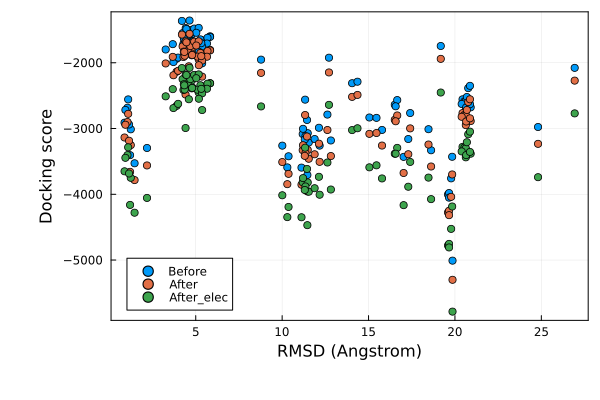

In [30]:
scatter(rmsds, current_score_b, 
        label="Before",
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

scatter!(rmsds, current_score, 
        label="After", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

scatter!(rmsds, score, 
        label="After_elec", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

In [31]:
current_score_trained_b = MDToolbox.docking_score(receptor, ligands, 0.01, iface_trained[1:end])

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


100-element Vector{Float64}:
 -2832.4157196799997
 -1974.170919720001
 -2079.5264231239994
 -3025.983140907001
 -2081.3638237380005
 -1894.2798281999997
 -2130.6316461650003
 -1897.1357527889995
 -1853.5879077969998
 -2805.616440188
 -2214.0730355689984
 -1992.5061088699997
 -3227.390328084
     ⋮
 -3091.2083898450005
 -2152.5118605469997
 -4663.738142397999
 -3618.107392085001
 -3111.4582580929987
 -1834.3259103319992
 -2803.9636165089983
 -2763.815993455001
 -3030.5206768049998
 -2030.75696851
 -2286.222083837001
 -2024.3001110599998

In [32]:
current_score_trained_a = docking_score(receptor, ligands, 0.01, iface_trained[1:end])

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


100-element Vector{Float64}:
 -3077.18009468
 -2180.868419720001
 -2287.270798123999
 -3273.345015907001
 -2282.275073738
 -2097.5723282
 -2336.514771165
 -2098.1113777889996
 -2054.456032797
 -3057.083315188
 -2412.1755355689984
 -2194.1629838699996
 -3487.127203084
     ⋮
 -3360.1471398450003
 -2377.472485547
 -4954.854392397999
 -3884.3248920850006
 -3358.4407580929987
 -2028.474660331999
 -3069.4111165089985
 -2998.3016184550006
 -3267.8169268049996
 -2234.0738435099997
 -2487.698333837001
 -2219.78698606

In [33]:
score_elec = docking_score_elec(receptor, ligands, 0.01, iface_trained[1:end], 3.0, charge[1:end])

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


100-element Vector{Float64}:
 -3566.18009468
 -2678.868419720001
 -2790.270798123999
 -3774.345015907001
 -2783.275073738
 -2587.5723282
 -2831.514771165
 -2597.1113777889996
 -2559.456032797
 -3550.083315188
 -2931.1755355689984
 -2690.1629838699996
 -3982.127203084
     ⋮
 -3847.1471398450003
 -2880.472485547
 -5438.854392397999
 -4375.324892085
 -3858.4407580929987
 -2525.474660331999
 -3563.4111165089985
 -3492.3016184550006
 -3767.8169268049996
 -2735.0738435099997
 -2997.698333837001
 -2731.78698606

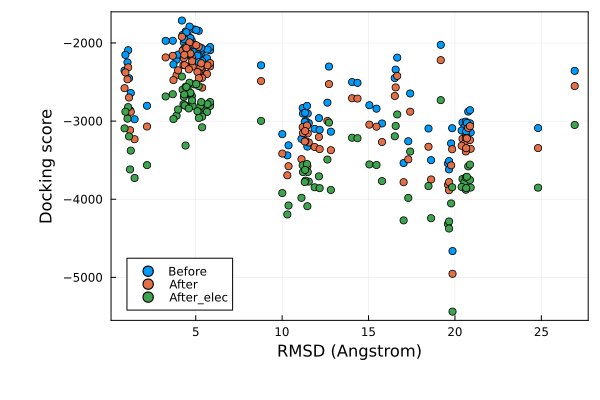

In [34]:
scatter(rmsds, current_score_trained_b, 
        label="Before",
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

scatter!(rmsds, current_score_trained_a, 
        label="After", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

scatter!(rmsds, score_elec, 
        label="After_elec", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

In [68]:
hage = sum(current_score_trained_a - current_score_trained_b)/100

-223.48691249999996

In [69]:
hoge = sum(score_elec - current_score_trained_a)/100

-501.37

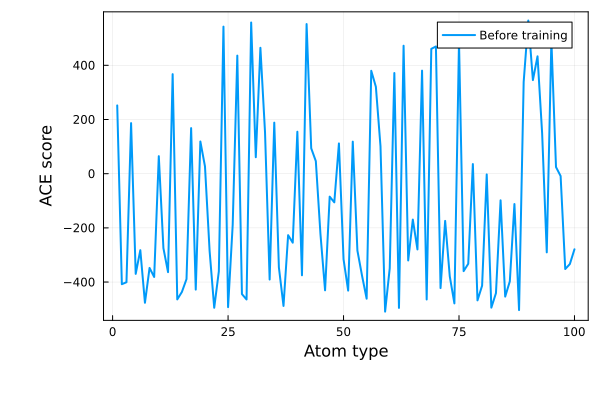

In [64]:
plot(hoge[1:end], 
     linewidth=2, 
     xlabel="Atom type", ylabel="ACE score", label="Before training",  
     size=(600, 400), frame_style=:box, 
     legend=:topright, 
     left_margin=Plots.Measures.Length(:mm, 10.0),
     bottom_margin=Plots.Measures.Length(:mm, 10.0))

# create ideal scores as training data

In [35]:
# create training score
x1 = minimum(rmsds)
x2 = maximum(rmsds)

y1 = maximum(score)
y2 = minimum(score)

train_score = zeros(Float64, ntop)
for i = 1:ntop
    train_score[i] = (y2 - y1) / (x2 - x1) * (rmsds[i] - x1) + y1
end

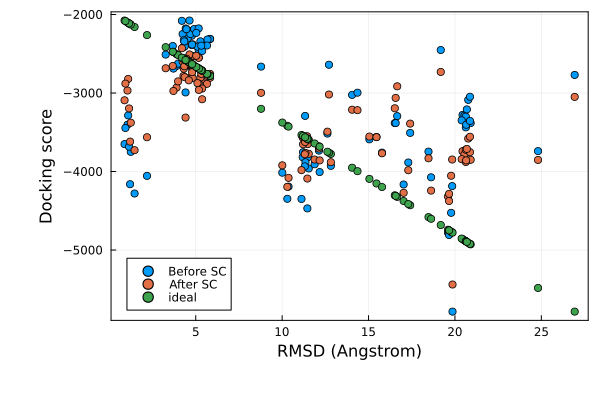

In [36]:
scatter(rmsds, score, 
        label="Before SC",
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

scatter!(rmsds, score_elec, 
        label="After SC", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft,  
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

scatter!(rmsds, train_score, 
        label="ideal", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft,  
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

In [37]:
loss_elec = sum((score_elec .- train_score).^2)

5.60483429801089e7

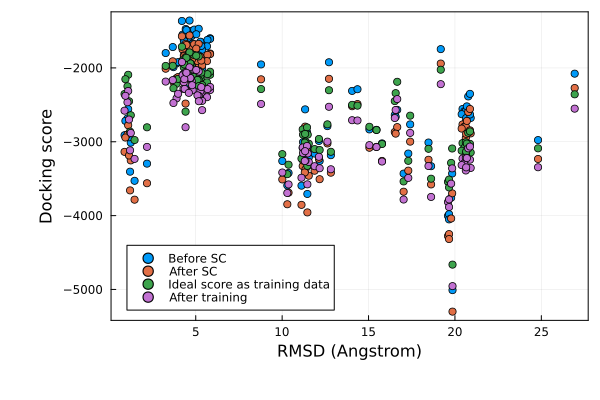

In [38]:
scatter(rmsds, current_score_b, 
        label="Before SC",
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

scatter!(rmsds, current_score, 
        label="After SC", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft,  
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

scatter!(rmsds, current_score_trained_b, 
        label="Ideal score as training data", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft,  
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

scatter!(rmsds, current_score_trained_a, 
        label="After training", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

In [39]:
loss1 = sum((current_score .- train_score).^2)

1.3810477947110042e8

In [40]:
loss2 = sum((current_score_b .- train_score).^2)

1.742870133978353e8

In [41]:
loss3 = sum((current_score_trained_b .- train_score).^2)

1.2615622945009886e8

In [42]:
loss4 = sum((current_score_trained_a .- train_score).^2)

9.377659366264567e7

In [43]:
loss1 / loss2

0.7923985658980586

In [44]:
loss4 / loss3

0.7433370042161813

In [45]:
loss4 / loss1

0.6790249694600121

# define the docking score function as a layer of neural net framework (Flux.jl)

In [70]:
#ニューラルネットワークフレームワーク(Flux)のレイヤとしてドッキングスコア評価関数を定義

using Flux

struct DockingScore
    A::AbstractArray
    iface_score::AbstractArray
end

DockingScore() = DockingScore(0.01, iface_score[1:end])

Flux.@functor DockingScore (A,iface_score)

(m::DockingScore)(x) = MDToolbox.docking_score(x[1], x[2], m.A[1], m.iface_score[1:end])

In [71]:
# パラメータとして alpha と aces_core が認識されていることを確認
m = DockingScore()
ps = Flux.params(m)

LoadError: MethodError: [0mCannot `convert` an object of type 
[0m  [92mFloat64[39m[0m to an object of type 
[0m  [91mAbstractArray[39m
[0mClosest candidates are:
[0m  convert(::Type{T}, [91m::TrjArray[39m) where T<:AbstractArray at ~/.julia/packages/MDToolbox/R7KUd/src/trjarray.jl:832
[0m  convert(::Type{T}, [91m::LinearAlgebra.Factorization[39m) where T<:AbstractArray at /Applications/Julia-1.7.app/Contents/Resources/julia/share/julia/stdlib/v1.7/LinearAlgebra/src/factorization.jl:58
[0m  convert(::Type{T}, [91m::T[39m) where T<:AbstractArray at /Applications/Julia-1.7.app/Contents/Resources/julia/share/julia/base/abstractarray.jl:16
[0m  ...

In [48]:
ps = ps |> Flux.gpu

LoadError: UndefVarError: ps not defined

In [49]:
train_score = CUDA.cu(train_score)

LoadError: CUDA driver not found

In [50]:
# 勾配降下法によるパラメータの最適化

loss(receptor_ligands, train_scores) = sum(Flux.Losses.mse.(m.(receptor_ligands), train_scores))

train_loader = Flux.Data.DataLoader((data=[(receptor, ligands)], label=[train_score]), batchsize=1, shuffle=false);

opt = ADAM(0.1)
    
loss_train = []
for epoch in 1:100
    for (x, y) in train_loader
        gs = gradient(() -> loss(x, y), ps)
        Flux.Optimise.update!(opt, ps, gs)
    end
    push!(loss_train, loss([(receptor, ligands)], [train_score]))
end

LoadError: UndefVarError: ps not defined

In [51]:
loss_train

Any[]

# visualize the trained results

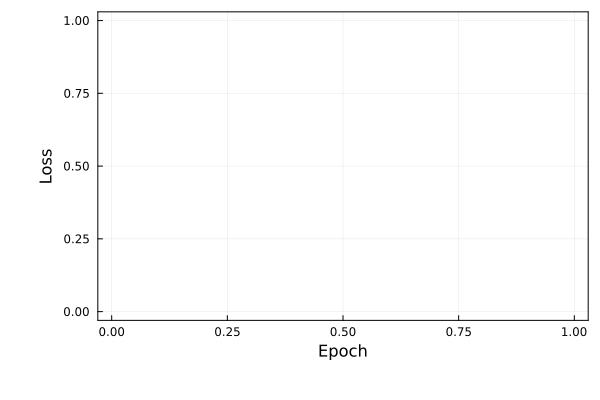

In [52]:
# 損失関数(Loss function)が学習とともに減少しているか確認
plot(loss_train, 
     linewidth=2, 
     xlabel="Epoch", ylabel="Loss", label=nothing,  
     size=(600, 400), frame_style=:box, 
     legend=:topright, 
     left_margin=Plots.Measures.Length(:mm, 10.0),
     bottom_margin=Plots.Measures.Length(:mm, 10.0))

In [53]:
# 学習後のドッキングスコアをプロット
aftertrain_score = MDToolbox.docking_score(receptor, ligands, m.A[1], m.iface_score)

scatter(rmsds, current_score, 
        label="Before training", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:topright, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

scatter!(rmsds, train_score, 
        label="Ideal score as training data", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft, color=2, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

scatter!(rmsds, aftertrain_score, 
        label="After training", 
        xlabel="RMSD (Angstrom)", ylabel="Docking score", 
        size=(600, 400), frame_style=:box, 
        legend=:bottomleft, color=3, 
        left_margin=Plots.Measures.Length(:mm, 10.0),
        bottom_margin=Plots.Measures.Length(:mm, 10.0))

LoadError: UndefVarError: m not defined

In [54]:
# 学習後の ace_scores をプロット
plot(iface_score[1:end], 
     linewidth=2, 
     xlabel="Atom type", ylabel="ACE score", label="Before training",  
     size=(600, 400), frame_style=:box, 
     legend=:topright, 
     left_margin=Plots.Measures.Length(:mm, 10.0),
     bottom_margin=Plots.Measures.Length(:mm, 10.0))

plot!(m.iface_score, 
     linewidth=2, 
     xlabel="Atom type", ylabel="ACE score", label="After training",
     linecolor=:green,
     size=(600, 400), frame_style=:box, 
     legend=:topright, 
     left_margin=Plots.Measures.Length(:mm, 10.0),
     bottom_margin=Plots.Measures.Length(:mm, 10.0))

LoadError: UndefVarError: m not defined

In [55]:
m.iface_score

LoadError: UndefVarError: m not defined

In [56]:
@show iface_score

iface_score = [0.678 0.133 -0.007 0.727 0.091 -0.742 -0.625 -0.064 -0.382 -0.302 1.221 0.187; 0.133 0.18 0.065 0.295 0.057 -0.631 -0.663 0.612 0.342 -0.275 0.604 0.248; -0.007 0.065 -0.145 0.093 -0.265 -1.078 -1.176 0.636 0.355 -0.552 0.483 0.109; 0.727 0.295 0.093 0.696 -0.016 -0.735 -0.804 0.525 0.144 -0.202 1.116 0.477; 0.091 0.057 -0.265 -0.016 -0.601 -0.928 -1.046 0.644 0.615 -0.573 0.062 -0.034; -0.742 -0.631 -1.078 -0.735 -0.928 -0.914 -1.696 -0.577 -0.43 -1.495 -0.303 -0.867; -0.625 -0.663 -1.176 -0.804 -1.046 -1.696 -1.938 -0.214 0.015 -1.771 0.092 -1.04; -0.064 0.612 0.636 0.525 0.644 -0.577 -0.214 1.62 1.233 -0.001 0.368 0.822; -0.382 0.342 0.355 0.144 0.615 -0.43 0.015 1.233 1.09 0.05 -0.024 0.757; -0.302 -0.275 -0.552 -0.202 -0.573 -1.495 -1.771 -0.001 0.05 -1.606 0.253 -0.572; 1.221 0.604 0.483 1.116 0.062 -0.303 0.092 0.368 -0.024 0.253 1.884 0.731; 0.187 0.248 0.109 0.477 -0.034 -0.867 -1.04 0.822 0.757 -0.572 0.731 0.399]


12×12 Matrix{Float64}:
  0.678   0.133  -0.007   0.727   0.091  -0.742  -0.625  -0.064  -0.382  -0.302   1.221   0.187
  0.133   0.18    0.065   0.295   0.057  -0.631  -0.663   0.612   0.342  -0.275   0.604   0.248
 -0.007   0.065  -0.145   0.093  -0.265  -1.078  -1.176   0.636   0.355  -0.552   0.483   0.109
  0.727   0.295   0.093   0.696  -0.016  -0.735  -0.804   0.525   0.144  -0.202   1.116   0.477
  0.091   0.057  -0.265  -0.016  -0.601  -0.928  -1.046   0.644   0.615  -0.573   0.062  -0.034
 -0.742  -0.631  -1.078  -0.735  -0.928  -0.914  -1.696  -0.577  -0.43   -1.495  -0.303  -0.867
 -0.625  -0.663  -1.176  -0.804  -1.046  -1.696  -1.938  -0.214   0.015  -1.771   0.092  -1.04
 -0.064   0.612   0.636   0.525   0.644  -0.577  -0.214   1.62    1.233  -0.001   0.368   0.822
 -0.382   0.342   0.355   0.144   0.615  -0.43    0.015   1.233   1.09    0.05   -0.024   0.757
 -0.302  -0.275  -0.552  -0.202  -0.573  -1.495  -1.771  -0.001   0.05   -1.606   0.253  -0.572
  1.221   0.604   

In [57]:
using BSON: @save, @load

@save "iface_score.bson" Array(m.iface_score)

LoadError: LoadError: Unrecognised @save expression Array(m.iface_score)
in expression starting at In[57]:3

In [58]:
iface_score

12×12 Matrix{Float64}:
  0.678   0.133  -0.007   0.727   0.091  -0.742  -0.625  -0.064  -0.382  -0.302   1.221   0.187
  0.133   0.18    0.065   0.295   0.057  -0.631  -0.663   0.612   0.342  -0.275   0.604   0.248
 -0.007   0.065  -0.145   0.093  -0.265  -1.078  -1.176   0.636   0.355  -0.552   0.483   0.109
  0.727   0.295   0.093   0.696  -0.016  -0.735  -0.804   0.525   0.144  -0.202   1.116   0.477
  0.091   0.057  -0.265  -0.016  -0.601  -0.928  -1.046   0.644   0.615  -0.573   0.062  -0.034
 -0.742  -0.631  -1.078  -0.735  -0.928  -0.914  -1.696  -0.577  -0.43   -1.495  -0.303  -0.867
 -0.625  -0.663  -1.176  -0.804  -1.046  -1.696  -1.938  -0.214   0.015  -1.771   0.092  -1.04
 -0.064   0.612   0.636   0.525   0.644  -0.577  -0.214   1.62    1.233  -0.001   0.368   0.822
 -0.382   0.342   0.355   0.144   0.615  -0.43    0.015   1.233   1.09    0.05   -0.024   0.757
 -0.302  -0.275  -0.552  -0.202  -0.573  -1.495  -1.771  -0.001   0.05   -1.606   0.253  -0.572
  1.221   0.604   

In [59]:
m.A

LoadError: UndefVarError: m not defined

In [60]:
loss_train

Any[]